# LSTM Stock Price Prediction

## Start with imports, downloading and preparing data.

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

start_date = '2010-01-01'
end_date = '2020-01-01'
ticker = 'INVE-B.ST'
df = yf.download(ticker, start_date, end_date)
df.index = df.index.date
df.index.name = "Date"

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,33.375000,33.875000,33.375000,33.825001,23.078617,6739900
2010-01-05,33.875000,34.099998,33.775002,34.000000,23.198017,2981928
2010-01-07,33.724998,34.224998,33.674999,33.900002,23.129789,6745776
2010-01-08,34.049999,34.099998,33.750000,33.950001,23.163902,5780292
2010-01-11,34.125000,34.250000,33.900002,33.950001,23.163902,5140340


In [ ]:
df1 = df.reset_index()['Adj Close']

plt.plot(df1)

We want to scale the dataset in order to use it for LSTM.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

Now we can split it into training and testing

In [ ]:
training_size = int(len(df1)*0.8)
test_size = len(df1)-training_size
train_data, test_data =df1[0:training_size,:],df1[training_size:len(df1),:1]

print(training_size, test_size)

now we convert the values into a dataset matrix using this function.

In [44]:
def create_dataset (dataset, time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [45]:
time_step = 100

X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data, time_step)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1907, 100) (1907,)
(402, 100) (402,)


Now we reshape the input to be [sample, time steps, features]

In [46]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape,X_test.shape)

(1907, 100, 1) (402, 100, 1)


Now we can create the LSTM model

In [93]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [94]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
30/30 [==============================] - 3s 42ms/step - loss: 0.0341 - val_loss: 0.0346
Epoch 2/100
30/30 [==============================] - 1s 31ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/100
30/30 [==============================] - 1s 30ms/step - loss: 3.4957e-04 - val_loss: 4.3938e-04
Epoch 4/100
30/30 [==============================] - 1s 31ms/step - loss: 2.7046e-04 - val_loss: 4.5312e-04
Epoch 5/100
30/30 [==============================] - 1s 30ms/step - loss: 2.4695e-04 - val_loss: 4.8519e-04
Epoch 6/100
30/30 [==============================] - 1s 30ms/step - loss: 2.3697e-04 - val_loss: 5.1710e-04
Epoch 7/100
30/30 [==============================] - 1s 30ms/step - loss: 2.2624e-04 - val_loss: 7.3287e-04
Epoch 8/100
30/30 [==============================] - 1s 31ms/step - loss: 2.1759e-04 - val_loss: 7.9715e-04
Epoch 9/100
30/30 [==============================] - 1s 32ms/step - loss: 2.1050e-04 - val_loss: 8.5950e-04
Epoch 10/100
30/30 [========================

In [96]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

print(train_predict.shape,test_predict.shape)

13/13 [==============================] - 0s 7ms/step
(1907, 1) (402, 1)


In [97]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [100]:
import math
from sklearn.metrics import mean_squared_error,r2_score
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))
print(r2_score(y_train,train_predict))
print(r2_score(y_test,test_predict))

0.008917459836559564
0.01767041250310276
0.9981972036929716
0.9739746335983674


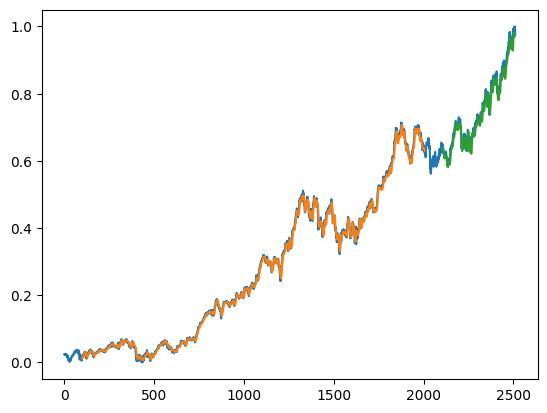

In [99]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()